### Importing Dependencies

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import keras

In [13]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [14]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [15]:
processed_texts[:5]

["antidepressants free U.S???I'm México antidepressants cheap plus bought recipe Anyways going psychiatrist prescribed medicine anxiety miraculous felt good life course going psychotherapist wondering expensive U.S cause México cheap know suffering long cure right pretty solid price",
 'buddys dad got fired wanted teach online friends dad fired teaching Nd job told teach class online needed large family immunocompromised covid huge risk petitioners set help job single person help greatly appreciated https://www.change.org/p/ltisd-administrators-save-schmidt',
 'Attempted SuicideLast week decided 5000 mg 5 Grams Zoloft 20 mg Klonopin took hesitant found weird time attempting suicide hesitant scared time calm scared surprised wake find alive thought dosage kill read people overdose died took know use think commit suicide attempt proven wrong time bit scared fear kept alive fear gone feels like life movement hesitation ER ended vomiting sleeping recall vomiting sleeping effects overdosing

In [16]:
lengths = [len(processed_text) for processed_text in processed_texts if len(processed_text) < 2000]

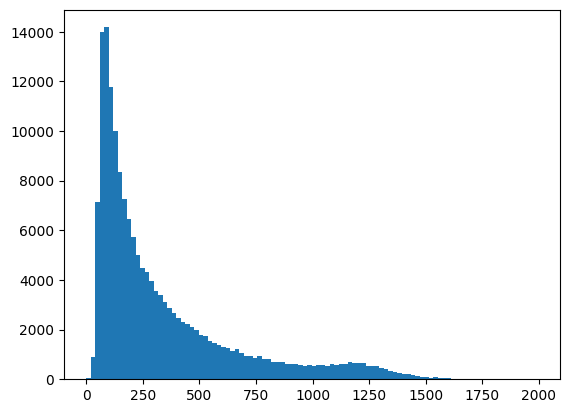

In [17]:
plt.hist(lengths, bins=100)
plt.show()

### Creating the Model

#### Vectorization

In [18]:
TextVectorization = keras.layers.TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=3000,
    output_mode='int',
    output_sequence_length=200,
)

vectorize_layer.adapt(processed_texts + processed_val_texts)

In [19]:
vectorized_texts = vectorize_layer(processed_texts)

In [20]:
vectorized_val_texts = vectorize_layer(processed_val_texts)

#### Model 1

In [21]:
from keras_tuner import HyperParameters as hp
Sequential = keras.models.Sequential

model = Sequential([
    keras.layers.Embedding(3001, 16),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20),
    keras.layers.Dense(1, activation='tanh')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [22]:
model.fit(vectorized_texts, labels, epochs=10, validation_data=(vectorized_val_texts, val_labels), callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ])

Epoch 1/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 172s 33ms/step - accuracy: 0.7489 - loss: 0.4717 - val_accuracy: 0.9281 - val_loss: 0.2129
Epoch 2/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 176s 34ms/step - accuracy: 0.8974 - loss: 0.2563 - val_accuracy: 0.9357 - val_loss: 0.2039
Epoch 3/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 173s 33ms/step - accuracy: 0.9267 - loss: 0.2075 - val_accuracy: 0.9381 - val_loss: 0.1927
Epoch 4/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 174s 33ms/step - accuracy: 0.9402 - loss: 0.1762 - val_accuracy: 0.9380 - val_loss: 0.1803
Epoch 5/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 172s 33ms/step - accuracy: 0.9425 - loss: 0.1674 - val_accuracy: 0.9406 - val_loss: 0.1930
Epoch 6/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 172s 33ms/step - accuracy: 0.9444 - loss: 0.1678 - val_accuracy: 0.9314 - val_loss: 0.1919
Epoch 7/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 174s 33ms/step - accuracy: 0.9425 - loss: 0.1668 - val_accuracy: 0.9400 - val_loss: 0.1654
Epoch 8/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 171s 33ms/step - accuracy: 

##### Evaluating the Model

In [23]:
vectorized_test_texts = vectorize_layer(processed_test_texts)

#### Saving Model

In [24]:
best_model = model
with open('../models/gru_last.pkl', 'wb') as fp:
    pickle.dump(model, fp)

In [25]:
best_model.summary()
_ = best_model.evaluate(vectorized_test_texts, test_labels)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 16)        │        48,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 200, 20)        │         2,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 20)             │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,513 (619.20 KB)

 Trainable params: 52,837 (206.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,676 (412.80 KB)

589/589 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9271 - loss: 0.1978


In [26]:
y_pred = best_model.predict(vectorized_test_texts)
y_pred = (y_pred > 0.5).astype(int)
y_pred = np.array(list(map(lambda x: x[0], y_pred)))

589/589 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

print(f'accuracy_score {accuracy_score(test_labels, y_pred):.3f}')
print(f'precision_score {precision_score(test_labels, y_pred):.3f}')
print(f'recall_score {recall_score(test_labels, y_pred):.3f}')
print(f'f1_score {f1_score(test_labels, y_pred):.3f}')

False Positive Rate: 0.1323
False Negative Rate: 0.0210
accuracy_score 0.931
precision_score 0.908
recall_score 0.979
f1_score 0.942


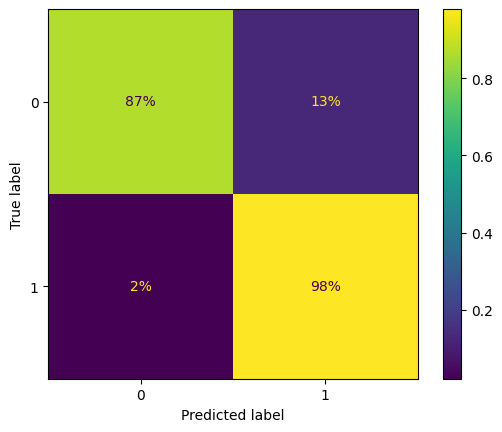

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()